In [31]:
import librosa, librosa.display
import numpy as np
from pydub import AudioSegment
import my_utils
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import time

n_fft = 1024
hop_length = 8
sr = 16000

# cate bucati PF iau in considerare pentru AF -> cu overlapping => 15 frame-uri 
# ultimul frame din AF fiind PF-ul curent
# nb_of_PFs_per_AF = 4
nb_of_frames_in_AF = 4
exp_w_avg_beta = 0.98
marja_eroare = 0.01

In [20]:
def get_STFT_AF_frames(AF_array, PF_size):
    frames = []
    half = (int)(PF_size/2)
    frames_added = 0
    
    i = AF_array.shape[0]-1
    
    # use AF as 4 times bigger than PF's size -> PF = 10 ms => AF = 40 ms
    
    #---------------------------------------------------------------------------
    # 1. add PF[i]
    frame = librosa.stft(librosa.to_mono(AF_array[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    
    tensor = []
    tensor.append(frame)        
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 2. add PF[i-1, i] -> overlap
    overlap_frame = AF_array[i-1][half:]
    overlap_frame = np.concatenate((overlap_frame, AF_array[i][:half]))
    
    frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)

    tensor = []
    tensor.append(frame)
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 3. add PF[i - 1]
    frame = librosa.stft(librosa.to_mono(AF_array[i - 1]), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    
    tensor = []
    tensor.append(frame)        
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 4. add PF[i-1, i] -> overlap
    overlap_frame = AF_array[i-1][half:]
    overlap_frame = np.concatenate((overlap_frame, AF_array[i][:half]))
    
    frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)

    tensor = []
    tensor.append(frame)
    frames.append(tensor)
                      
#     for i in range (0, AF_array.shape[0]):

#         # 1. add current frame from AF
#         frame = librosa.stft(librosa.to_mono(AF_array[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
#         frame = np.abs(frame)
        
#         tensor = []
#         tensor.append(frame)        
#         frames.append(tensor)
        
#         # 2. add overlapped frame if the current frame is not the last one
#         if i < AF_array.shape[0]-1:
#             overlap_frame = AF_array[i][half:]
#             overlap_frame = np.concatenate((overlap_frame, AF_array[i+1][:half]))
            
#             frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
#             frame = np.abs(frame)

#             tensor = []
#             tensor.append(frame)
#             frames.append(tensor)
        
    
    return np.asarray(frames)

In [21]:
def get_train_set_for_mix(mix, voice_1, voice_2, samples_per_frame):
    inputs = []
    targets = []
    
    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_1_frames = np.array([voice_1[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_2_frames = np.array([voice_2[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    
    for index in range(mix_frames.shape[0]):
        
        if index < 2:
            continue
        
        # 1. create train set input for AF with current PF and previous frames
        AF_frames = np.array([mix_frames[i] for i in range(index - 2, index)])      
        AF_STFT_frames = get_STFT_AF_frames(AF_array=AF_frames, PF_size= samples_per_frame)
        inputs.append(AF_STFT_frames)
        
        # 2. create train set target for that AF, containing the mask for the current PF
        stft_voice_1 = librosa.stft(librosa.to_mono(voice_1_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        stft_voice_2 = librosa.stft(librosa.to_mono(voice_2_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        mask = my_utils.compute_mask(stft_voice_1, stft_voice_2)
        
        targets.append(mask)
    
    # train set for only one audio
    train_set_input = torch.from_numpy(np.array(inputs))
#     print(train_set_input.shape)
    
    # target contains the calculated masks for each PF from mix
    train_set_target = torch.from_numpy(np.array(targets))

#     train_set = dict(zip(train_set_input[:398, :, :], train_set_target[:398, :, :]))
#     valid_set = dict(zip(train_set_input[398:448, :, :], train_set_target[398:448, :, :]))
#     test_set = dict(zip(train_set_input[448:498, :, :], train_set_target[448:498, :, :]))
#     return train_set, train_set_target

#     train_set = dict(zip(train_set_input, train_set_target))
#     return train_set, train_set, train_set
    return np.array(inputs), np.array(targets)
    

In [22]:
def get_train_set_for_mix_noise(mix, voice_1, voice_2, samples_per_frame):
    inputs = []
    targets = []
    
    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_1_frames = np.array([voice_1[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_2_frames = np.array([voice_2[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    
    for index in range(mix_frames.shape[0]):
        
        if index < 2:
            continue
        
        # 1. create train set input for AF with current PF and previous frames
        AF_frames = np.array([mix_frames[i] for i in range(index - 2, index)])      
        AF_STFT_frames = get_STFT_AF_frames(AF_array=AF_frames, PF_size= samples_per_frame)
        inputs.append(AF_STFT_frames)
        
        # 2. create train set target for that AF, containing the mask for the current PF
        stft_voice_1 = librosa.stft(librosa.to_mono(voice_1_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        stft_voice_2 = librosa.stft(librosa.to_mono(voice_2_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        mask = my_utils.compute_mask(stft_voice_1, stft_voice_2)
        
        targets.append(mask)
    
    # train set for only one audio
    train_set_input = torch.from_numpy(np.array(inputs))
#     print(train_set_input.shape)
    
    # target contains the calculated masks for each PF from mix
    train_set_target = torch.from_numpy(np.array(targets))

#     train_set = dict(zip(train_set_input[:398, :, :], train_set_target[:398, :, :]))
#     valid_set = dict(zip(train_set_input[398:448, :, :], train_set_target[398:448, :, :]))
#     test_set = dict(zip(train_set_input[448:498, :, :], train_set_target[448:498, :, :]))
#     return train_set, train_set_target

#     train_set = dict(zip(train_set_input, train_set_target))
#     return train_set, train_set, train_set
    return np.array(inputs), np.array(targets)

In [23]:
class Network(nn.Module):
    height = 0
    width = 0
    
    # default values for height and width are given for a processing frame of 10 ms
    # 5 ms  = [513, 11]
    def __init__(self, height = 513, width = 21):
        super(Network, self).__init__()
        self.height = height
        self.width = width
        
        # layer 1
        self.fc1 = nn.Linear(1 * height * width, 250)
        self.fc1_batch = nn.BatchNorm1d(250)#momentum=0.5)
        
        # layer 2
        self.fc2 = nn.Linear(250, 250)
        self.fc2_batch = nn.BatchNorm1d(250)#momentum=0.5)
        
        # layer 3
        self.fc3 = nn.Linear(250, height * width)
        self.fc3_batch = nn.BatchNorm1d(height * width)#momentum=0.5)

    def forward(self, x):
        
        # layer 1
        # firstly, transform the matrix into an array for the FC
        x = x.view(-1, self.height * self.width)        
        x = self.fc1(x)
        x = self.fc1_batch(x)
#         x = torch.sigmoid(x)
        x = torch.relu(x)
#         x = self.fc1_batch(x)
#         print("1 shapes: ", x.shape)
        
        # layer 2
        x = self.fc2(x)
        x = self.fc2_batch(x)
#         x = torch.sigmoid(x)
        x = torch.relu(x)
#         x = self.fc2_batch(x)
#         print("2 shapes: ", x.shape)
        
        # layer 3
        x = self.fc3(x)
        x = self.fc3_batch(x)
#         x = torch.sigmoid(x)
        x = torch.relu(x)
#         x = self.fc3_batch(x)
        
        x = x.view(nb_of_frames_in_AF, self.height, self.width) 
#         print("3 shapes: ", x.shape)
        
        return x

In [24]:
# create network
# no params => default params for 10 ms frame
# 10 ms -> 513, 21
# 5 ms -> 513, 11
# network = Network()

# # if cuda is available, send network's params to gpu
# if torch.cuda.is_available():
#     torch.cuda.empty_cache()
#     print("network sent to CUDA")
#     network.cuda()
    
# # set optimizer -> article : Adam, lr = 0.001, b1 = 0.9, b2 = 0.999
# optimizer = optim.Adam(network.parameters(), lr = 0.001, betas = (0.9, 0.999))
# optimizerSGD = optim.SGD(network.parameters(), momentum=0.9, weight_decay=10e-4, lr=0.001)
loss_function = nn.MSELoss()

In [25]:
def make_mix_of_5_seconds(voice):
    nb_sample_for_5_seconds = 80000
    
    if len(voice) < nb_sample_for_5_seconds:
        voice = np.pad(voice, (0,(nb_sample_for_5_seconds - len(voice) )), 'constant', constant_values=(0))
    elif len(voice) > nb_sample_for_5_seconds:
        voice = voice[0:nb_sample_for_5_seconds]
    
    return voice        

In [26]:
def create_set_from_voices_lists(voice1_file_names_list, voice2_file_names_list):
    inputs_list = []
    targets_list = []
    
    frame_length_ms = 10
    total_length_ms = 5000.0
    nb_of_samples = 80000
    samples_per_frame = (int)(nb_of_samples * frame_length_ms / total_length_ms)
    
    for voice1_file_name in voice1_file_names_list:
        for voice2_file_name in voice2_file_names_list:
            
#             print("voices: ", voice1_file_name, voice2_file_name)
            voice1, sr = librosa.load(voice1_file_name, sr=16000) 
            voice2, sr = librosa.load(voice2_file_name, sr=16000) 

            # pad smaller array with zeros if it's the case or delete last entries
            voice1 = make_mix_of_5_seconds(voice1)
            voice2 = make_mix_of_5_seconds(voice2)

            # load the mixed audio 
            mix = voice1 + voice2

            voice1 = np.array(voice1)
            voice2 = np.array(voice2)
            mix = np.array(mix)

            inputs, targets = get_train_set_for_mix(mix, voice1, voice2, samples_per_frame)
            inputs_list.extend(inputs)
            targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    
    print("dims for train set: ", inputs_list.shape, targets_list.shape)
    
    network_set = dict(zip(inputs_list, targets_list))
    
    return network_set

In [27]:
def create_valid_set_from_voices_lists(voice1_file_names_list, voice2_file_names_list, noise_filename):
    inputs_list = []
    targets_list = []
    
    frame_length_ms = 10
    total_length_ms = 5000.0
    nb_of_samples = 80000
    samples_per_frame = (int)(nb_of_samples * frame_length_ms / total_length_ms)
    
    i = 1
    for voice1_file_name in voice1_file_names_list:
        for voice2_file_name in voice2_file_names_list:
            
#             print("voices: ", voice1_file_name, voice2_file_name)
            voice1, sr = librosa.load(voice1_file_name, sr=16000) 
            voice2, sr = librosa.load(voice2_file_name, sr=16000) 
            noise, sr = librosa.load(noise_filename, sr=16000) 

            # pad smaller array with zeros if it's the case or delete last entries
            voice1 = make_mix_of_5_seconds(voice1)
            voice2 = make_mix_of_5_seconds(voice2)

            # load the mixed audio 
            mix = voice1 + voice2
            
            if i % 2 == 1:
                noise = make_mix_of_5_seconds(noise)
                noise = noise / 5
                mix += noise

            voice1 = np.array(voice1)
            voice2 = np.array(voice2)
            mix = np.array(mix)

            inputs, targets = get_train_set_for_mix(mix, voice1, voice2, samples_per_frame)
            inputs_list.extend(inputs)
            targets_list.extend(targets)
            i += 1
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    
    print("dims for valid set: ", inputs_list.shape, targets_list.shape)
    
    network_set = dict(zip(inputs_list, targets_list))
    
    return network_set

In [28]:
def create_test_set_from_voices_lists(voice1_file_names_list, voice2_file_names_list, noise_filename):
    inputs_list = []
    targets_list = []
    
    frame_length_ms = 10
    total_length_ms = 5000.0
    nb_of_samples = 80000
    samples_per_frame = (int)(nb_of_samples * frame_length_ms / total_length_ms)
    
    for voice1_file_name in voice1_file_names_list:
        for voice2_file_name in voice2_file_names_list:
            
#             print("voices: ", voice1_file_name, voice2_file_name)
            voice1, sr = librosa.load(voice1_file_name, sr=16000) 
            voice2, sr = librosa.load(voice2_file_name, sr=16000) 
            noise, sr = librosa.load(noise_filename, sr = 16000)

            # pad smaller array with zeros if it's the case or delete last entries
            voice1 = make_mix_of_5_seconds(voice1)
            voice2 = make_mix_of_5_seconds(voice2)
            noise = make_mix_of_5_seconds(noise)

            # load the mixed audio 
            noise = noise / 5
            mix = voice1 + voice2 + noise

            voice1 = np.array(voice1)
            voice2 = np.array(voice2)
            mix = np.array(mix)

            inputs, targets = get_train_set_for_mix(mix, voice1, voice2, samples_per_frame)
            inputs_list.extend(inputs)
            targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    
    print("dims for test set: ", inputs_list.shape, targets_list.shape)
    
    network_set = dict(zip(inputs_list, targets_list))
    
    return network_set

In [29]:
def create_set_from_voices_lists_80_10_10(voice1_file_names_list, voice2_file_names_list):
    inputs_list = []
    targets_list = []
    
    noise_filename = 'recordings/noises/piano5sec.wav'
    noise, sr = librosa.load(noise_filename, sr=16000)
    noise = make_mix_of_5_seconds(noise)
    noise = noise / 5
    
    frame_length_ms = 10
    total_length_ms = 5000.0
    nb_of_samples = 80000
    samples_per_frame = (int)(nb_of_samples * frame_length_ms / total_length_ms)
    
    for voice1_file_name in voice1_file_names_list:
        for voice2_file_name in voice2_file_names_list:
            
#             print("voices: ", voice1_file_name, voice2_file_name)
            voice1, sr = librosa.load(voice1_file_name, sr=16000) 
            voice2, sr = librosa.load(voice2_file_name, sr=16000) 

            # pad smaller array with zeros if it's the case or delete last entries
            voice1 = make_mix_of_5_seconds(voice1)
            voice2 = make_mix_of_5_seconds(voice2)

            # load the mixed audio 
            mix = voice1 + voice2
            mix_noise = voice2 + noise

            voice1 = np.array(voice1)
            voice2 = np.array(voice2)
            mix = np.array(mix)
            mix_noise = np.array(mix_noise)

            inputs, targets = get_train_set_for_mix(mix, voice1, voice2, samples_per_frame)
            inputs_list.extend(inputs)
            targets_list.extend(targets)
            
            
            inputs, targets = get_train_set_for_mix(mix_noise, noise, voice2, samples_per_frame)
            inputs_list.extend(inputs)
            targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    
    print("dims for 80-10-10 set: ", inputs_list.shape, targets_list.shape)
    
    train_len = (int)(80/100 * len(inputs_list))
    m = (int)( (len(inputs_list) - train_len) / 2)

    train_set = dict(zip(inputs_list[:train_len, :, :], targets_list[:train_len, :, :]))
    valid_set = dict(zip(inputs_list[train_len:(train_len + m), :, :], targets_list[train_len:(train_len + m), :, :]))
    test_set = dict(zip(inputs_list[(train_len + m):len(inputs_list), :, :], targets_list[(train_len + m):len(inputs_list), :, :]))

    print("lens", len(train_set), len(valid_set), len(test_set))
    return train_set, train_set, train_set

In [45]:
voice1_file_names_list = ['recordings/voice1/arctic_a0007.wav']#, 'recordings/noises/piano5sec.wav']#, 'recordings/voice1/arctic_a0003.wav']
voice2_file_names_list = ['recordings/voice2/arctic_a0001.wav']#, 'recordings/voice2/arctic_a0002.wav', 'recordings/voice1/arctic_a0003.wav']#, 'recordings/noises/piano5sec.wav']#, 'recordings/voice1/arctic_a0003.wav']

voice1_file_names_list_valid = ['recordings/voice1/arctic_a0007.wav']#, 'recordings/voice1/arctic_a0003.wav']
voice2_file_names_list_valid = ['recordings/voice2/arctic_a0001.wav']#, 'recordings/voice2/arctic_a0002.wav']

voice1_file_names_list_test1 = ['recordings/voice1/arctic_a0007.wav']#, 'recordings/voice1/arctic_a0002.wav']
voice2_file_names_list_test1 = ['recordings/voice2/arctic_a0001.wav']#, 'recordings/voice2/arctic_a0001.wav']

voice1_file_names_list_test2 = ['recordings/voice1/arctic_a0007.wav']#, 'recordings/voice1/arctic_a0002.wav']
voice2_file_names_list_test2 = [noise_filename]#, 'recordings/voice2/arctic_a0001.wav']

voice1_file_names_list_test3 = ['recordings/voice1/arctic_a0007.wav']#, 'recordings/voice1/arctic_a0002.wav']
voice2_file_names_list_test3 = [noise2_filename]#, 'recordings/voice2/arctic_a0001.wav']

voice1_file_names_list_test4 = ['recordings/voice1/arctic_a0007.wav']#, 'recordings/voice1/arctic_a0002.wav']
voice2_file_names_list_test4 = [noise3_filename]#, 'recordings/voice2/arctic_a0001.wav']

noise_filename = 'recordings/noises/piano5sec.wav'
noise2_filename = 'recordings/noises/engine.wav'
noise3_filename = 'recordings/noises/beeps.wav'
# train_set_80, valid_set_10, test_set_10 = create_set_from_voices_lists_80_10_10(voice1_file_names_list, voice2_file_names_list)

train_set = create_set_from_voices_lists(voice1_file_names_list, voice2_file_names_list)
valid_set = create_valid_set_from_voices_lists(voice1_file_names_list_valid, voice2_file_names_list_valid, noise3_filename)
test_set1 = create_set_from_voices_lists(voice1_file_names_list_test1, voice2_file_names_list_test1)
test_set2 = create_set_from_voices_lists(voice1_file_names_list_test2, voice2_file_names_list_test2)
test_set3 = create_set_from_voices_lists(voice1_file_names_list_test3, voice2_file_names_list_test3)
test_set4 = create_set_from_voices_lists(voice1_file_names_list_test4, voice2_file_names_list_test4)


test_set1_noise = create_test_set_from_voices_lists(voice1_file_names_list_test1, voice2_file_names_list_test1, noise_filename)
test_set2_noise = create_test_set_from_voices_lists(voice1_file_names_list_test2, voice2_file_names_list_test2, noise2_filename)
test_set3_noise = create_test_set_from_voices_lists(voice1_file_names_list_test3, voice2_file_names_list_test3, noise_filename)
test_set4_noise = create_test_set_from_voices_lists(voice1_file_names_list_test4, voice2_file_names_list_test4, noise2_filename)

dims for train set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
dims for valid set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
dims for train set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
dims for train set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
dims for train set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
dims for train set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
dims for test set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
dims for test set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
dims for test set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
dims for test set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])


In [32]:
def train_network(nr_epochs, train_set, valid_set, model_name, optimizer, network):

    last_valid_loss = 0
    nb_of_epochs_for_valid_loss = 0
#     to_overfitting = 0

    # plot train/valid loss contains losses on each epoch, so we can see after each epoch what happens with the error
    plot_train_losses = []
    plot_valid_losses = []
    plot_train_accuracy = []
    plot_valid_accuracy = []


    epoch = 1
    while epoch <= nr_epochs:
        
#         if to_overfitting >= 10:
#             print("Stop training to prevent overfitting")
#             break
        
        mask = []
        mask_test = []
        
        correct_train = 0
        correct_test = 0

        train_losses, valid_losses = [], []
        loss = 0

        ## training part 
        network.train()
        for index, (input, target) in enumerate(train_set.items()):

            # target is transformed from a matrix to an array, so the error can be calculated easier
            # since the network returns an array

            # if cuda is available, send (input, target) to gpu
            if torch.cuda.is_available():
                input, target = input.cuda(), target.cuda()

            optimizer.zero_grad()

            # 1. forward propagation
            output = network(input)


            # 2. loss calculation
            loss = loss_function(target, output[len(output)-1])  


            # 3. backward propagation
            loss.backward() 


            # 4. weight optimization
            optimizer.step()


            # 5. save the loss for this PF
            train_losses.append(loss.item())

            
            # 6. check how many items where predicted correctly
            correct_train += 1 if loss.item() <= marja_eroare else 0 
            

        # add the mean loss for this training epoch for ploting
        train_mean_loss_for_epoch = np.mean(train_losses)
        plot_train_losses.append(train_mean_loss_for_epoch)
        
        current_accuracy = 100. * correct_train / len(train_set)
        plot_train_accuracy.append(current_accuracy)

#         print ("\nTraining loss: ", train_mean_loss_for_epoch)
        if epoch % 10 == 0 or epoch == 1:
            print("--------------------------------------Epoch", str(epoch) ,"------------------------------")
            print("Accuracy: {}/{} ({:.0f}%)\n".format(correct_train, len(train_set), current_accuracy))

#         if current_accuracy >= 90 :
#             to_overfitting += 1
        
        #-----------------------------------------------------------------------
        ## evaluation part 
        
        if epoch % 100 == 0:
#             network.eval()
            with torch.no_grad():
                for index, (input, target) in enumerate(valid_set.items()):

                    # if cuda is available, send (input, target) to gpu
                    if torch.cuda.is_available():
                         input, target = input.cuda(), target.cuda()

                     # 1. forward propagation
                    output = network.forward(input)

                     # 2. loss calculation
                    loss = loss_function(target, output[len(output)-1]).detach().item()

                     # 3. check how many items where predicted correctly
                    correct_test += 1 if loss <= marja_eroare else 0

                    if loss != last_valid_loss:
                        last_valid_loss = loss
                    else:
                        nb_of_epochs_for_valid_loss += 1

                    valid_losses.append(loss)

                 # add the mean loss for this training epoch for ploting
                valid_mean_loss_for_epoch = np.mean(valid_losses)
                plot_valid_losses.append(valid_mean_loss_for_epoch)
                
                current_accuracy = 100. * correct_test / len(valid_set)
                plot_valid_accuracy.append(current_accuracy)

                # check if we have the same loss for validation set
#                 if last_valid_loss - valid_mean_loss_for_epoch == 1e-3:
#                     print("!!!!!!!!!!!nb_of_epochs_for_valid_loss increased with one, loss:", last_valid_loss)
#                     nb_of_epochs_for_valid_loss += 1
#                 else:
#                     nb_of_epochs_for_valid_loss = 0
#                     last_valid_loss = valid_mean_loss_for_epoch

                    
                print ("\nValid loss: ", valid_mean_loss_for_epoch)
                print("Accuracy: {}/{} ({:.0f}%)\n".format(correct_test, len(valid_set),current_accuracy))


#             if(nb_of_epochs_for_valid_loss == 20):
#                 print("Early stopping training, valid acc is smaller than prev!")
#                 break
            
        epoch += 1

    torch.save(network, model_name)
    
    plt.plot(plot_train_losses, label='Training loss')
    plt.plot(plot_valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    
    plt.plot(plot_train_accuracy, label='Training accuracy')
    plt.plot(plot_valid_accuracy, label='Validation accuracy')
    plt.legend(frameon=False)
    plt.show()

In [33]:
# RECONSTRUIRE SUNET PE FRAME-URI, FOLOSIND TARGETURILE GENERATE PT SETUL DE ANTRENARE
def split_audios_epoch(name, mask, mix):
    
    frame_length_ms = 10
    total_length_ms = 5000.0
    nb_of_samples = 80000
    samples_per_frame = (int)(nb_of_samples * frame_length_ms / total_length_ms)
    
    frame_pos = (int)(nb_of_frames_in_AF/2)

    mask_stack = torch.stack(mask)
    cpu_mask = mask_stack.cpu()
    n_mask = cpu_mask.detach().numpy()

    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    sound1 = np.empty([0,])
    sound2 = np.empty([0,])


    for i in range (0, len(mix_frames)):
        stft_mix = librosa.stft(librosa.to_mono(mix_frames[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
        
        # reteaua nu a invatat mastile pentru primele frame_pos bucati [PF] din mix
        # deci las matricea STFT asa cum e in mix
        if i < frame_pos :
            y_frame_1_stft_with_mask = stft_mix
            y_frame_2_stft_with_mask = stft_mix

            inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
            inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')

            sound1 = np.concatenate((sound1, inverse_sound1_stft))
            sound2 = np.concatenate((sound2, inverse_sound2_stft))
            
        else:
            # n_mask[i-7] pentru ca reteaua invata pt AF-uri facute pe cate 8 PF-uri -> 15 items pt AF
            # abia de cand ajunge la primul AF care s a putut compune, folosesc masca invata de retea
            
            y_frame_1_stft_with_mask = np.multiply(n_mask[i-frame_pos], stft_mix)
            y_frame_2_stft_with_mask = np.multiply((1 -  n_mask[i-frame_pos]), stft_mix)

            inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
            inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')

            sound1 = np.concatenate((sound1, inverse_sound1_stft))
            sound2 = np.concatenate((sound2, inverse_sound2_stft))


    librosa.output.write_wav("recordings/voice1-"+ str(name) + ".wav", sound1, sr = 16000)
    librosa.output.write_wav("recordings/voice2-"+ str(name) + ".wav", sound2, sr = 16000)

In [34]:
def eval(network, test_set):

#     network.eval()
                
    test_loss, test_mask, test_accuracy = [], [], []
    target_height, target_width = 0, 0
    correct_test = 0

    for index, (input, target) in enumerate(test_set.items()):

        # if cuda is available, send (input, target) to gpu
        if torch.cuda.is_available():
            input, target = input.cuda(), target.cuda()

        # 1. forward propagation
        output = network.forward(input)

        # 2. loss calculation
        loss = loss_function(target, output[len(output)-1]).detach().item()

        # 3. save the mask for the current PF, meaning the last entry in the output
        current_mask = output[len(output)-1]#.view(target_height, target_width)
        test_mask.append(current_mask)

        test_loss.append(loss)
        
        # 4. check how many items where predicted correctly
        correct_test += 1 if loss <= marja_eroare else 0


    current_accuracy = 100. * correct_test / len(test_set)
    print("Test mix loss:", np.mean(test_loss))
    print("Mix accuracy: ", (int)(current_accuracy), '%')
    
    plt.plot(test_loss, label='Test loss')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend(frameon=False)
    plt.show()
    
    return test_mask

In [35]:
def runAdam(nr_epochs, model_name):
    network = Network()

    # if cuda is available, send network's params to gpu
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("network sent to CUDA")
        network.cuda()

    # set optimizer -> article : Adam, lr = 0.001, b1 = 0.9, b2 = 0.999
    optimizer = optim.Adam(network.parameters(), lr = 0.001, betas = (0.9, 0.999))

    start_time = time.time()

    train_network(nr_epochs=nr_epochs, 
                train_set=train_set, valid_set=valid_set, 
                model_name=model_name,
                optimizer=optimizer,
                network=network)
    
#     train_mask, valid_mask = train_network(nr_epochs=nr_epochs, 
#                                            train_set=train_set_80, valid_set=valid_set_10, 
#                                            model_name=model_name,
#                                           optimizer=optimizer,
#                                           network=network)

    elapsed_time = time.time() - start_time
    
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Elapsed time for " + model_name + " : {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    
#     eval(network=network, test_set=test_set_10)

In [36]:
def get_mix_from_voices(voice1_filename, voice2_filename):
    voice1, sr = librosa.load(voice1_filename, sr=16000) 
    voice2, sr = librosa.load(voice2_filename, sr=16000) 
    # pad smaller array with zeros if it's the case or delete last entries
    voice1 = make_mix_of_5_seconds(voice1)
    voice2 = make_mix_of_5_seconds(voice2)
    mix = voice1 + voice2
    
    return mix

In [37]:
def get_mix_from_voices_with_noise(voice1_filename, voice2_filename, noise_filename):
    voice1, sr = librosa.load(voice1_filename, sr=16000) 
    voice2, sr = librosa.load(voice2_filename, sr=16000) 
    noise, sr = librosa.load(noise_filename, sr=16000)
    # pad smaller array with zeros if it's the case or delete last entries
    voice1 = make_mix_of_5_seconds(voice1)
    voice2 = make_mix_of_5_seconds(voice2)
    noise = make_mix_of_5_seconds(noise)
    noise = noise / 5
    
    mix = voice1 + voice2 + noise
    
    return mix

In [47]:
def test_network(model_name, is_with_noise):
    voice1 = 'recordings/voice1/arctic_a0007.wav'
    
    
    voice2 = 'recordings/voice2/arctic_a0001.wav'
    voice3 = 'recordings/voice2/arctic_a0002.wav'
    voice4 = 'recordings/voice2/arctic_a0003.wav'
    voice5 = 'recordings/noises/piano5sec.wav'
    


    piano = 'recordings/noises/piano5sec.wav'
    engine = 'recordings/noises/engine.wav'

    mix1 = 0
    mix2 = 0
    mix3 = 0
    mix4 = 0
    if is_with_noise == True:
        mix1 = get_mix_from_voices_with_noise(voice1, voice2, piano)
        mix2 = get_mix_from_voices_with_noise(voice1, voice3, engine)
        mix3 = get_mix_from_voices_with_noise(voice1, voice4, piano)
        mix4 = get_mix_from_voices_with_noise(voice1, voice5, engine)
        
        network = torch.load(model_name)
        test_mask = eval(network=network, test_set=test_set1_noise)
        split_audios_epoch("-test1-noise-piano" + str(is_with_noise), test_mask, mix1)
    #     split_audios_epoch(model_name[2:] + "-test1-noise" + str(is_with_noise), test_mask, mix1)

        network = torch.load(model_name)
        test_mask = eval(network=network, test_set=test_set2_noise)
        split_audios_epoch("-test2-noise-engine" + str(is_with_noise), test_mask, mix2)

        network = torch.load(model_name)
        test_mask = eval(network=network, test_set=test_set3_noise)
        split_audios_epoch("-test3-noise-piano" + str(is_with_noise), test_mask, mix3)
        
        network = torch.load(model_name)
        test_mask = eval(network=network, test_set=test_set4_noise)
        split_audios_epoch("-test4-noise-engine" + str(is_with_noise), test_mask, mix4)
        
        
    else:
        mix1 = get_mix_from_voices(voice1, voice2)
        mix2 = get_mix_from_voices(voice1, voice3)
        mix3 = get_mix_from_voices(voice1, voice4)
        mix4 = get_mix_from_voices(voice1, voice5)
        
        network = torch.load(model_name)
        test_mask = eval(network=network, test_set=test_set1)
        split_audios_epoch("-test1-" + str(is_with_noise), test_mask, mix1)
    #     split_audios_epoch(model_name[2:] + "-test1-noise" + str(is_with_noise), test_mask, mix1)

        network = torch.load(model_name)
        test_mask = eval(network=network, test_set=test_set2)
        split_audios_epoch("-test2-" + str(is_with_noise), test_mask, mix2)

        network = torch.load(model_name)
        test_mask = eval(network=network, test_set=test_set3)
        split_audios_epoch("-test3-" + str(is_with_noise), test_mask, mix3)

        network = torch.load(model_name)
        test_mask = eval(network=network, test_set=test_set4)
        split_audios_epoch("-test4-" + str(is_with_noise), test_mask, mix4)

__________________________________________ADAM_________________________________
Test mix loss: 0.2573773962373002
Mix accuracy:  0 %


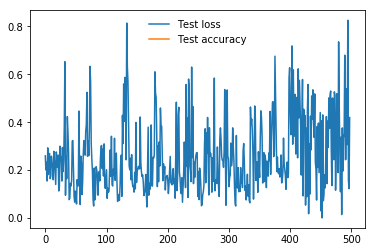

Test mix loss: 0.26503874443800574
Mix accuracy:  0 %


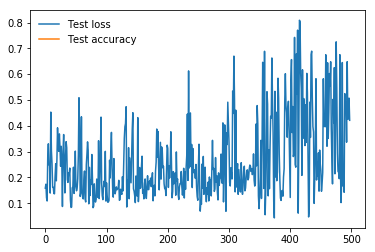

Test mix loss: 0.29752093408795366
Mix accuracy:  0 %


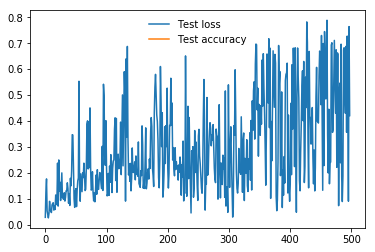

Test mix loss: 0.3060300865446229
Mix accuracy:  0 %


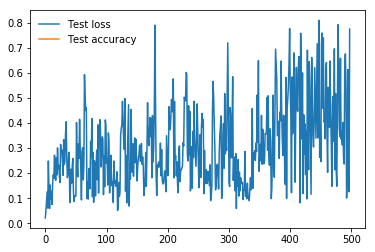

Test mix loss: 0.1918283970016672
Mix accuracy:  19 %


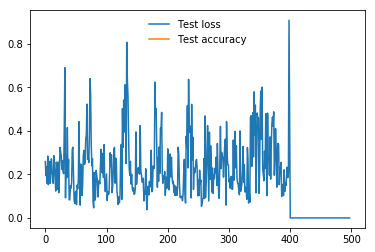

Test mix loss: 0.2640037361726943
Mix accuracy:  0 %


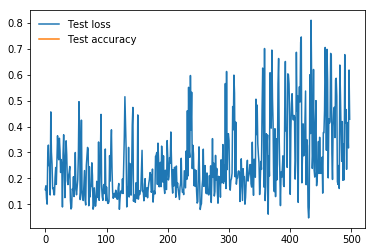

Test mix loss: 0.2957441965230258
Mix accuracy:  0 %


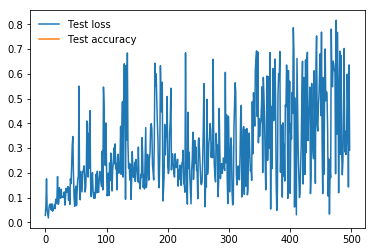

Test mix loss: 0.3203404432379577
Mix accuracy:  0 %


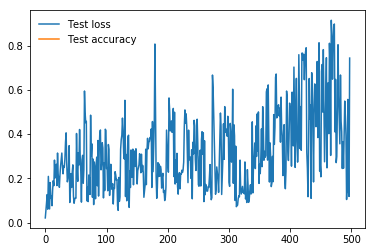

In [48]:
import winsound
import os

torch.cuda.empty_cache()
print("__________________________________________ADAM_________________________________")

model_name = './300e-train(71)-valid(71P)-test(noises).pth'
# model_name = "models/sss-model-Adam-600-4mixuri.pth"
# runAdam(300, model_name)


test_network(model_name, is_with_noise = True)
test_network(model_name, is_with_noise = False)

# os.system('shutdown -s')

duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)
